In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from copy import copy

from matplotlib import animation
import ipycanvas
from IPython.display import HTML

# Physics Simulation


A physics engine is computer software that provides an approximate simulation of certain physical systems, such as rigid body dynamics (including collision detection), soft body dynamics, and fluid dynamics, of use in the domains of computer graphics, video games and film (CGI). Their main uses are in video games (typically as middleware), in which case the simulations are in real-time. The term is sometimes used more generally to describe any software system for simulating physical phenomena


## 1. Introduction

Through this notebook I will describe and simulate things that naturally occurs in our physical world. In this notebook "the world" is 2D canvas.

## 2. Position and Displacement vector

To simulate any physical phenomenon first we must be able to describe its position. Where the object is at any particular time. The position of the object could be described as a vector relative to the origin of a coordinate system $ \vec{r} $


$$ \vec{r} = \begin{pmatrix} x \\ y \end{pmatrix} = x\hat{i} + y\hat{j} $$

In [5]:
def plot_vectors(vectors, colors):
    """
    Plots vectors on the xy-plane. The `vectors` parameter is a Python list.
    Each vector is specified in the format [start_x, start_y, end_x, end_y]
    """
    vectors = np.array(vectors)
    x_start = vectors[:, 0]
    y_start = vectors[:, 1]

    x_end = vectors[:, 2]
    y_end = vectors[:, 3]
    
    u = x_end - x_start
    v = y_end - y_start
    
    xlim_min = np.min(np.minimum(x_start, x_end))
    xlim_max = np.max(np.maximum(x_start, x_end))
    ylim_min = np.min(np.minimum(y_start, y_end))
    ylim_max = np.max(np.maximum(y_start, y_end))


    plt.scatter(x_end, y_end, color=colors)
    
    plt.xlim(xlim_min - 0.5, xlim_max + 0.5)
    plt.ylim(ylim_min - 0.5, ylim_max + 0.5)

    ax = plt.gca()
    plt.quiver(x_start, y_start, u, v, angles = "xy", scale_units = "xy", scale = 1, color=colors)
    ax.spines["bottom"].set_position("zero")
    ax.spines["left"].set_position("zero")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_aspect("equal")

    plt.show()

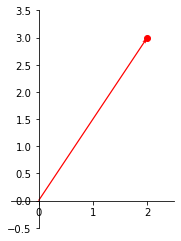

In [6]:
plot_vectors([[0, 0, 2, 3]] ,["red"])

If an object moves to some position relative to its original position then object position changes. This change is called displacement.


$$ \Delta\vec{r} = \vec{r_{n+1}} - \vec{r_n} $$


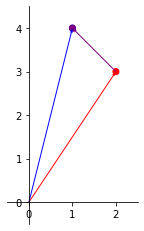

In [7]:
r1 = np.array([2, 3])
r2 = np.array([1, 4])
dr = r2 - r1

r1 = [0, 0, 2, 3]
r2 = [0, 0, 1, 4]
dr = [2, 3, 1, 4]

plot_vectors([r1, r2, dr], ["red", "blue", "purple"])

red point is the initial position, blue point is the new position , purple vector is the displacement vector

Objects in motion can also have series of displacements. The total displacements is sum of individual displacements

$$  \Delta\vec{s_{total}} = \sum_{i = 0}^{n} \Delta\vec{r_i}  $$

The total distance traveled is the sum of the magnitudes of all displacement vectors

$$ s_{total} = \sum_{i = 0}^{n} \left | \Delta\vec{r_i}  \right | $$

## 3. Velocity

Motion is the phenomenon in which an object changes its position overtime. Velocity $ \vec{v} $ is a vector quantity that measures displacement $ {\Delta}\vec{s} $  over the change in time $ {\Delta}t $. In other words velocity is rate of change of position over time.


$$ \vec{v} = \frac{{\Delta}\vec{s}}{{\Delta}t} = \frac{ {\Delta}\vec{s_{n+1}} - {\Delta}\vec{s_{n}} }{t_{n+1} - t_{n}} $$


In [8]:
t = np.arange(0, 10, 1)
x = np.arange(0, 10, 1)
y = x

s = np.array([(x_i, y_i) for x_i, y_i in zip(x, y)])

v_01 = (s[1] - s[0]) / (t[1] - t[0])
v_average = np.add.reduce([ (s[i+1] - s[i]) / (t[i+1] - t[i]) for i in range(len(s)-1)])/(t[9] - t[0])
print(f"Velocity between s[1] and s[0]: {v_01}")
print(f"Average veloctity: {v_average}")

Velocity between s[1] and s[0]: [1. 1.]
Average veloctity: [1. 1.]


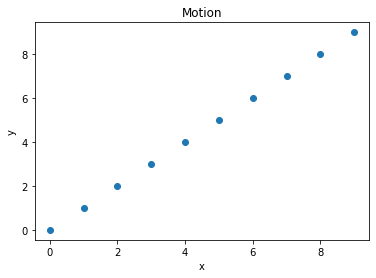

In [9]:
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Motion")
plt.show()

To find velocity at any position(instantaneous velocity) we let $ t_{1} = t $ and $ t_{2} = t + {\Delta}t $. After inserting these expressions in the equation for velocity and get the limit as $ {\Delta}t \rightarrow 0$. We find the expression for the instantaneous velocity:

$$ \vec{v}(t) = \lim_{{\Delta}t \rightarrow 0}{\frac{\vec{s}(t + {\Delta}t) - \vec{s}(t)}{{\Delta}t}} = \frac{d\vec{s}(t)}{dt} $$    

## 4. Acceleration

Acceleration is rate of change of velocity over time. 

$$ \vec{a} = \frac{{\Delta}\vec{v}}{{\Delta}t} = \frac{ {\Delta}\vec{v_{n+1}} - {\Delta}\vec{v_{n}} }{t_{n+1} - t_{n}} $$

To find acceleration at any position(instantaneous acceleration) we let $ t_{1} = t $ and $ t_{2} = t + {\Delta}t $. After inserting these expressions in the equation for acceleration and get the limit as $ {\Delta}t \rightarrow 0$. We find the expression for the instantaneous acceleration:

$$ \vec{a}(t) = \lim_{{\Delta}t \rightarrow 0}{\frac{\vec{v}(t + {\Delta}t) - \vec{v}(t)}{{\Delta}t}} = \frac{d\vec{v}(t)}{dt} $$

## 5. Simulator with ipycanvas

### 5.1 ipycanvas coordinate system

As opposite to matplotlib, where its origin is located at bottom left corner, in the coordinate system defined by [ipycanvas](https://ipycanvas.readthedocs.io/en/latest/index.html), origin is located at top left corner. All elements are placed relative to this origin. For example top left corner of the blue square is located x pixels from the left and y pixels from the top at coordinates (x, y)

![coordinate system](https://ipycanvas.readthedocs.io/en/latest/_images/grid.png)

### 5.2 Vector

In [10]:
class Vector2D:
    def __init__(self, x, y):
        """
            two dimensional vector
        """
        self.x = x
        self.y = y

    def mag(self):
        return math.sqrt(self.x**2 + self.y**2)
        
    def normalize(self):
        return self / self.mag()
        
    def limit(self, maxm):
        if self.mag > maxm:
            multiplier = maxm/self.mag
        else:
            multiplier = 1.0

        return self * multiplier
        
    def __add__(self, other):
        if isinstance(other, Vector2D):
            return Vector2D(self.x + other.x, self.y + other.y)
        return Vector2D(self.x + other, self.y + other)

    def __sub__(self, other):
        if isinstance(other, Vector2D):
            return Vector2D(self.x - other.x, self.y - other.y)
        return Vector2D(self.x - other, self.y - other.y)

    def __mul__(self, other):
        if isinstance(other, Vector2D):
            return self.x * other.x + self.y * other.y
        return Vector2D(self.x * other, self.y * other)
    
    def __truediv__(self, scalar):
        return self * (1/scalar)
    
    def __gt__(self, other):
        return self.mag > other.mag
        
    def __str__(self):
        return f"({self.x}, {self.y})"

### 5.3 Object2D

In [11]:
class Object2D:
    def __init__(self, position):
        """
            Object which is controled by the simulation
            possition - 2D vector describing displacement from 0,0
        """
        self.position = position
        self.previous_position = position
        self.forces = []

    def draw(self, canvas, position):
        """
            draw object on the canvas
        """
        raise NotImplemented()

    def update(self, canvas, dt):
        """
            update the object
        """
        raise NotImplemented()
        
    def on_collision(self, other, collied):
        raise NotImplemented()

### 5.4 Simulation

In [12]:
class Simulation:
    def __init__(self, width=200, height=200, collision_detector = None):
        self.width = width
        self.height = height
        self.multi_canvas = ipycanvas.MultiCanvas(
            2, width=self.width, height=self.height)

        self.background_canvas = self.multi_canvas[1]
        self.background_canvas.stroke_style = "black"
        self.background_canvas.stroke_rect(0, 0, self.width, self.height)

        self.canvas = self.multi_canvas[0]
        display(self.multi_canvas)
        self.objects = []
        self.collision_detector = collision_detector

    def add_object(self, object2D):
        """
            Add Object2D to the simulation
        """
        self.objects.append(object2D)

    def draw(self, alpha, dt):
        """
            Draw every Object2D to the canvas
        """
        with ipycanvas.hold_canvas(self.multi_canvas):
            self.canvas.clear()

            for obj in self.objects:
                position = (obj.position * alpha) + \
                   (obj.previous_position * (1 - alpha))
                obj.previous_position = position
                obj.draw(self.canvas, position)
                
    def update(self, dt):
        """
            phisics update every Object2D
        """

        # apply forces
        new_objects = []
        for obj in self.objects:
            new_object = copy(obj)

            new_object.update(self.canvas, dt)
            new_object.previous_position = obj.position

            new_objects.append(new_object)

            
        self.objects = new_objects
        
        if self.collision_detector:
            # collision detection
            collisions_objects = []
            for obj in self.objects:
                new_object = copy(obj)

                for other in self.objects:
                    if obj != other:
                        new_object.on_collision(other, self.collision_detector(obj, other))

                collisions_objects.append(new_object)

            self.objects = collisions_objects
                    
    def run(self, period=5, fps=100, dt=None):
        """
            period - simulation time in seconds 
            Run Simation:
                1. Update
                2. Draw
        """
        accumulator = 0

        start_frame = time.time()
        simulation_time = 0
        frameDelay = 1 / fps
        
        if not dt:
            dt = frameDelay

        self.frames = 0

        while simulation_time < period:
            self.frames += 1
            now = time.time()

            # calculate how much time took last frame
            last_frame = now - start_frame

            simulation_time += last_frame

            # store the time elapsed sinse the last frame began
            accumulator += last_frame

            # if we accumulate too much time
            if accumulator > 0.2:
                accumulator = dt

            # record starting of this frame
            start_frame = now

            # accumulate enough time to update the physics. update at delta time
            steps = 0
            while accumulator > dt:
                self.update(dt)
                accumulator -= dt
                steps += 1

            draw_start = time.time()

            self.draw(accumulator/dt, dt)

            draw_time = time.time() - draw_start

            # cap the fps because ipycanvas jupyter communication limitations
            if frameDelay > draw_time:
                time.sleep(frameDelay - draw_time)

In [13]:
class Rectangle(Object2D):
    def __init__(self, position, width, height, velocity=Vector2D(0, 0), accelaration=Vector2D(0, 0)):
        super().__init__(position)
        self.velocity = velocity
        self.accelaration = accelaration
        self.width = width
        self.height = height

    def update(self, canvas, dt):
        self.velocity += self.accelaration * dt
        self.position += self.velocity * dt

    def draw(self, canvas, position):
        canvas.fill_rect(position.x,
                         position.y, self.width, self.height)


In [14]:
sim = Simulation(200, 200)
rect = Rectangle(position=Vector2D(0, 0),
                 width=20, height=20,
                 velocity=Vector2D(0, 0), 
                 accelaration=Vector2D(50, 50))

sim.add_object(rect)
sim.run(2)

MultiCanvas(height=200, width=200)

In [15]:
class Static(Rectangle):
    def __init__(self, position, width, height):
        super().__init__(position, width, height)
        self.width = width
        self.height = height

    def update(self, canvas, dt):
        pass


class Follower(Rectangle):
    def __init__(self, position, width, height,  goto):
        super().__init__(position, width, height)
        self.width = width
        self.height = height
        self.goto = goto
        self.a_factor = 100

    def update(self, canvas, dt):
        direction = (self.goto - self.position).normalize()

        self.accelaration = direction * self.a_factor
        super().update(canvas, dt)

    def draw(self, canvas, position):

        canvas.global_alpha = 0.1
        super().draw(canvas, position)
        canvas.global_alpha = 1
        canvas.stroke_style = "black"
        canvas.stroke_rect(position.x,
                           position.y, self.width, self.height)

In [16]:
sim = Simulation(500, 200)

static = Static(position=Vector2D(240, 90),
               width=10, height=10)

n = 1
for f_i in range(10):
    n *= -1 
    sim.add_object(Follower(position=Vector2D( ( 5 + (f_i * 20)) , n*30 + (f_i * 10)), width=10, height=10, goto=static.position))

sim.add_object(static)

sim.run(10)

MultiCanvas(height=200, width=500)

## 5. Forces. Newton's laws of motion

A force is a vector that causes an object with mass to accelerate. It is mathematical tool that is introduced in Newton’s theory of physics.

### 5.1 Newton’s First Law

The first law states that an object at rest will stay at rest, and an object in motion will stay in motion unless acted on by a net external force. Mathematically, this is equivalent to saying that if the net force on an object is zero, then the velocity of the object is constant.


$$ \vec{F} = 0 \Leftrightarrow \frac{d\vec{v}(t)}{dt} = 0  $$

### 5.2 Newton's Second Law

The second law states that the rate of change of momentum of a body over time is directly proportional to the force applied, and occurs in the same direction as the applied force. For objects with constant mass:


$$ \vec{F} = \frac{d(m{\vec{v}}(t))}{dt} = m\frac{d{\vec{v}}(t)}{dt} = m\vec{a} $$

### 5.3 Newton's Third Law

The third law states that all forces between two objects exist in equal magnitude and opposite direction: if one object $ A $ exerts a force $\vec{F_A}$ on a second object $ B $, then $ B $ simultaneously exerts a force $ \vec{F_B} $ on $ A $, and the two forces are equal in magnitude and opposite in direction: 

$$ \vec{F_A} = -\vec{F_B} $$

In [17]:
class NewtonCircle(Object2D):
    def __init__(self, position, radius, mass):
        super().__init__(position)
        self.radius = radius
        self.mass = mass
        self.velocity = Vector2D(0, 0)
        self.acceleration = Vector2D(0, 0)
        self.forces = []
    
    def bounce(self, canvas):
        if self.position.x+self.radius > canvas.width:
            self.position.x = canvas.width - self.radius
            self.velocity.x *= -1
            
        elif self.position.x < 0:
            self.position.x = 0
            self.velocity.x *= -1
            
            
        if self.position.y+self.radius > canvas.height:
            self.position.y = canvas.height - self.radius
            self.velocity.y *= -1
            
        elif self.position.y < 0:
            self.position.y = 0
            self.velocity.y *= -1
    
    def add_force(self, force):
        self.forces.append(force)
    
    def draw(self, canvas, position):
        canvas.stroke_style = "black"
        canvas.stroke_circle(position.x, position.y, self.radius)
        
        canvas.global_alpha = 0.3
        canvas.fill_circle(position.x, position.y, self.radius)
        canvas.global_alpha = 1
        
    def apply_forces(self):
        for force in self.forces:
            self.acceleration += (force / self.mass)
            
    def update(self, canvas, dt):
        
        self.apply_forces()

        self.velocity += self.acceleration * dt
        self.position += self.velocity * dt
    
        self.bounce(canvas)
    
        self.acceleration *= 0 

In [18]:
sim = Simulation(500, 200)

circle = NewtonCircle(position=Vector2D(240, 90),
                      radius=10,
                      mass=1)

circle1 = copy(circle)
circle1.velocity = Vector2D(0, 100)

sim.add_object(circle)
sim.add_object(circle1)
sim.run(1)

MultiCanvas(height=200, width=500)

Newton's first law. Objects do not change their states without forces.

In [19]:
sim = Simulation(500, 200)


f1 = Vector2D(200, 0);
f2 = Vector2D(0, 1000);

circle = NewtonCircle(position=Vector2D(240, 90),
                      radius=10,
                      mass=5)

circle1 = NewtonCircle(position=Vector2D(240, 90),
                      radius=20,
                      mass=10)

circle.add_force(f1)
circle.add_force(f2)

circle1.add_force(f1)
circle1.add_force(f2)

sim.add_object(circle)
sim.add_object(circle1)

sim.run(10)

MultiCanvas(height=200, width=500)

Newton's second law. Forces are proportional to the mass

In [20]:
sim = Simulation(500, 200)


f1 = Vector2D(1000, 0);

circle = NewtonCircle(position=Vector2D(240, 90),
                      radius=10,
                      mass=10)

circle.add_force(f1)
circle.add_force(f1*-1)

sim.add_object(circle)

sim.run(1)

MultiCanvas(height=200, width=500)

Newton's third law. Forces are canceled out.

## 6. Collision detection

Collision detection is the computational problem of detecting the intersection of two or more objects.
Algorithms to detect collision in 2D world depend on the type of shapes that can collide (e.g. Rectangle to Rectangle, Rectangle to Circle, Circle to Circle).

### 1.  Axis-Aligned Bounding Box (AABB)

Axis-Aligned Bounding Box collision detection, or AABB for short, is one of the simplest forms of collision detection. The Bounding Box part of the name just refers to a rectangular structure that defines the surface area of an object. Axis-Aligned means that the bounding boxes of the objects being compared for collision are aligned on both their x and y axes.


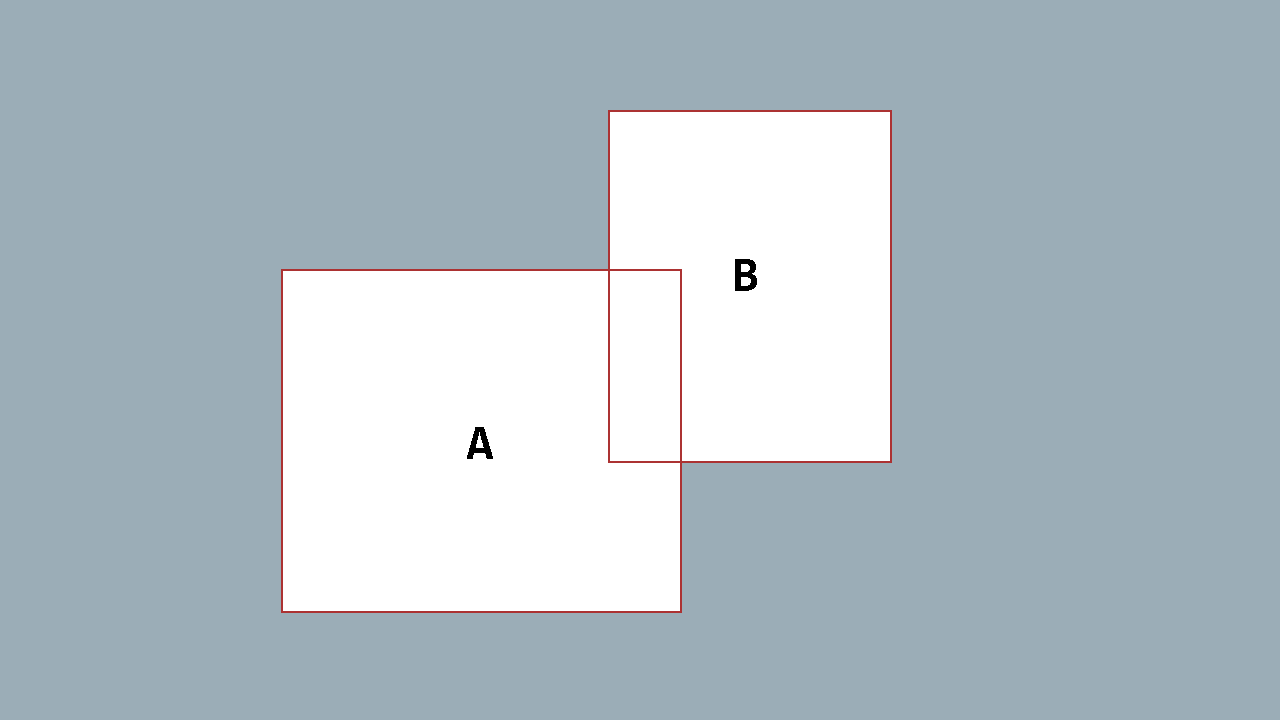


The x and y axes of both boxes are aligned, which means we can use AABB collision detection to check for collision between them.

In [21]:
class RectCollider(Object2D):
    def __init__(self, position, width, height, mass=1, fill_style_collision="red"):
        super().__init__(position)
        self.width = width
        self.height = height
        self.others = []
        self.velocity = Vector2D(0, 0)
        self.mass = mass
        self.fill_style = "black"
        self.fill_style_collision = fill_style_collision
                
    def bounce(self, canvas):
        if self.position.x+self.width > canvas.width:
            self.position.x = canvas.width - self.width
            self.velocity.x *= -1

        if self.position.x < 0:
            self.position.x = 0
            self.velocity.x *= -1


    def update(self, canvas, dt):
        self.position += self.velocity * dt
        self.bounce(canvas)

    def draw(self, canvas, position):
        canvas.stroke_style = "black"
        canvas.stroke_rect(position.x, position.y,
                           self.width, self.height)

        canvas.global_alpha = 0.3
        canvas.fill_style = self.fill_style
        canvas.fill_rect(position.x, position.y,
                         self.width, self.height)
        canvas.global_alpha = 1
        
    def on_collision(self, other, collide):
        if collide:
            self.fill_style = self.fill_style_collision
        else:
            self.fill_style = "black"

In [22]:
def AABBColisionDetection(A, B):
    """
        AABB
    """
    if A.position.x < (B.position.x + B.width) \
        and (A.position.x + A.width) > B.position.x \
        and A.position.y < (B.position.y + B.height) \
            and (A.position.y + A.height) > B.position.y:
            return True

    else:
        return False

sim = Simulation(500, 200, AABBColisionDetection)

v = Vector2D(200, 0)

obj1 = RectCollider( position=Vector2D(0, 75),
                     width = 50,
                     height = 50,
                     fill_style_collision = "red")
obj1.velocity = v
obj2 = RectCollider( position=Vector2D(450, 75),
                     width = 50,
                     height = 50,
                    fill_style_collision = "blue")
obj2.velocity = v*-1

sim.add_object(obj1)
sim.add_object(obj2)
sim.run(5)

MultiCanvas(height=200, width=500)

### Elastic collision


An elastic collision is an encounter between two bodies in which the total kinetic energy of the two bodies remains the same. In an ideal, perfectly elastic collision, there is no net conversion of kinetic energy into other forms such as heat, noise, or potential energy. 

In an elastic collision, both momentum and kinetic energy are conserved. Consider object 1 and 2 with masses $ m_1 , m_2 $, and velocities $ \vec{u_1}, \vec{u_2} $ before collision, $ \vec{u_1}, \vec{u_2} $ after collision. 

The conservation of the total momentum before and after the collision is expressed by:

$$ m_1\vec{u_1} + m_2\vec{u_2} = m_1\vec{v_1} + m_1\vec{v_2} $$


Likewise, the conservation of the total kinetic energy is expressed by:

$$ \frac{1}{2}m_1\vec{u_1^2} + \frac{1}{2}m_2\vec{u_2^2} = \frac{1}{2}m_1\vec{v_1^2} + \frac{1}{2}m_2\vec{v_2^2} $$

These equations may be solved directly to find $\vec{v_1}, \vec{v_2}$ when $\vec{u_1}, \vec{u_2}$ are known:


$$ \vec{v_1} = \frac{m_1 - m_2}{m_1 + m_2}\vec{u_1} + \frac{2m_2}{m_1 + m_2}\vec{u_2}$$

$$ \vec{v_2} = \frac{2m_1}{m_1 + m_2}\vec{u_1} + \frac{m_2 - m_1}{m_1 + m_2}\vec{u_2}$$



In [23]:
class ElasticCollision(RectCollider):
    def __init__(self, position, width, height, mass=1):
        super().__init__(position, width, height, mass)

    def on_collision(self, other, collide):
        global collisions_cnt
        if collide:
            mass_sum = self.mass + other.mass
            new_velocity = (self.velocity * ((self.mass - other.mass) / mass_sum)) + (other.velocity*((2*other.mass)/mass_sum))
            
            self.velocity = new_velocity

sim = Simulation(500, 200, AABBColisionDetection)

v = Vector2D(100, 0)

obj1 = ElasticCollision(position=Vector2D(100, 30),
                     width = 40,
                     height = 20,
                     mass=2)

obj1.velocity = v
obj2 = ElasticCollision(position=Vector2D(300, 30),
                       width = 20,
                       height = 20)
obj2.velocity = v*-1
sim.add_object(obj1)
sim.add_object(obj2)

obj3 = ElasticCollision(position=Vector2D(50, 60),
                       width = 20,
                       height = 20)

obj3.velocity = v
obj4 = ElasticCollision(position=Vector2D(250, 60),
                       width = 20,
                       height = 20)

sim.add_object(obj3)
sim.add_object(obj4)

obj5 = ElasticCollision(position=Vector2D(50, 90),
                       width = 20,
                       height = 20)

obj5.velocity = v
obj6 = ElasticCollision(position=Vector2D(250, 90),
                       width = 20,
                       height = 20)
obj6.velocity = (v*-1)/2

sim.add_object(obj5)
sim.add_object(obj6)


obj7 = ElasticCollision(position=Vector2D(50, 120),
                       width = 20,
                       height = 20)

obj7.velocity = v
obj8 = ElasticCollision(position=Vector2D(100, 120),
                       width = 20,
                       height = 20)
obj8.velocity = v/2

sim.add_object(obj7)
sim.add_object(obj8)

sim.run(20)

MultiCanvas(height=200, width=500)

### Approximation of PI using collisions

- https://www.youtube.com/watch?v=PoW8g67XNxA
- https://www.youtube.com/watch?v=jsYwFizhncE

In [24]:
collisions_cnt = 0
class ElasticCollision(RectCollider):
    def __init__(self, position, width, height, mass=1):
        super().__init__(position, width, height, mass)
    
    def update(self, canvas, dt):
        global collisions_cnt
        self.position += self.velocity * dt
        
        if self.position.x < 0:
            self.position.x = 0
            self.velocity.x *= -1
            collisions_cnt+=1

    def on_collision(self, other, collide):
        global collisions_cnt
        if collide:
            mass_sum = self.mass + other.mass
            new_velocity = (self.velocity * ((self.mass - other.mass) / mass_sum)) + (other.velocity*((2*other.mass)/mass_sum))
            
            self.velocity = new_velocity
            collisions_cnt += 1

class ElasticCollisionB(RectCollider):
    def __init__(self, position, width, height, mass=1):
        super().__init__(position, width, height, mass)
    
    def update(self, canvas, dt):
        self.position += self.velocity * dt
    
    def on_collision(self, other, collide):
        if collide:
            mass_sum = self.mass + other.mass
            new_velocity = (self.velocity * ((self.mass - other.mass) / mass_sum)) + (other.velocity*((2*other.mass)/mass_sum))
            
            self.velocity = new_velocity
            
sim = Simulation(700, 200, AABBColisionDetection)

#v = Vector2D(500, 0)

obj1 = ElasticCollision( position=Vector2D(100, 115),
                     width = 10,
                     height = 10)
#obj1.velocity = v
obj2 = ElasticCollisionB(position=Vector2D(450, 75),
                     width = 50,
                     height = 50, mass=100000000)

obj2.velocity =  Vector2D(-1000, 0)

sim.add_object(obj1)
sim.add_object(obj2)
sim.run(15, 60, 1/1000000)
print(collisions_cnt)

MultiCanvas(height=200)

31415


## 7. Fluid Simulation


Two main categories of simulation methods exist: 
 - Grid based(Eulerian)
 - Particle based(Lagrangian)
 
Grid based methods uses grid of points to track fluid motion. Each point has information about velocity of the flow passing through them, the current density and how it changes.

Particle based methods uses particles to track fluid motion. The particles maintain certain field properties such as velocity and pressure.
The state of the field can be evaluated at any position by sampling all particles
by using a smoothing kernel function. This method is called Smoothen Particles Hydrodynamics. Particle properties are calculated based on its neighbors in a given radius.  Particles
closer to the center has more effect on the resulting value and particles outside of
the radius does not effect the value at all.

Implemented algorithm is based on [CBP05](http://www.ligum.umontreal.ca/Clavet-2005-PVFS/pvfs.pdf). The algorithm aims to solve Navier-Stokes equations.

According to the paper incompressibility of the fluid is enforced with a double density relaxation procedure with updates particle position. Two different measures of the particles' neighbor density is used to decide the impulses between the particles.

$$ \rho = \sum_{n{\in}neighbors_p}\left(1-\frac{|p.pos - n.pos|}{radius}\right)^2 $$
$$ \rho_{near} = \sum_{n{\in}neighbors_p}\left(1-\frac{|p.pos - n.pos|}{radius}\right)^3 $$

These densities are used to calculate pseudo pressure $P$ and near pressure $P_{near}$

$$ P = k(\rho - \rho_0) $$
$$ P_{near} = k_{near} \rho_{near} $$

where $k$ and $k_{near}$ are stiffness constants and $\rho_0 $ is rest density



In [25]:
class Particle:
    def __init__(self, pos):
        self.pos = pos
        self.pos_prev = pos + Vector2D(np.random.rand(), np.random.rand())
        self.vel = Vector2D(0, 0)
        self.force = Vector2D(0, 0)
        self.rho = 0
        self.rho_near = 0
        self.press = 0
        self.press_near = 0
        self.neighbors = []

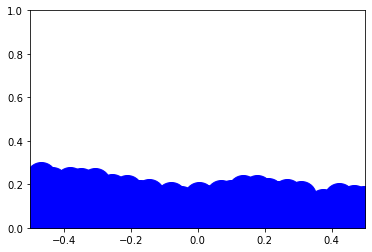

In [26]:
class FluidSim:
    def __init__(self):
        self.sim_width = 0.5

        self.N = 200
        self.G = 0.02 * 0.25

        self.spacing = 0.1
        self.k = self.spacing / 1000
        self.k_near = self.k * 10
        self.rest_density = 5
        self.r = self.spacing * 1.25

        self.max_vel = 2
        self.wall_damp = 0.05

        self.sigma = 0.1

        self.particles = []

        self.init_particles2(-self.sim_width, 0, 0.15, 0.03)

        self.fig = plt.figure()
        self.axes = self.fig.add_subplot(xlim=(-self.sim_width, self.sim_width), ylim=(0, self.sim_width*2))
        self.points, = self.axes.plot([], [], "bo", ms=30)

    def init_particles2(self, x_start, y_start, x_end, space):
        x = x_start
        y = y_start
        for _ in range(self.N):
            p = Particle(Vector2D(x, y))
            self.particles.append(p)
            x += space
            if x > x_end:
                x = x_start
                y += space

    def integrate(self, p):
        # Verlet integration delta time = 1
        p.pos_prev = p.pos
        p.pos += p.vel

        # Apply accumulate force
        p.pos += p.force

        # reset the force only with gravity
        p.force = Vector2D(0, -self.G)

        # Calculate new velocity for the next step
        p.vel = p.pos - p.pos_prev

        # Limit the velocity
        if p.vel.mag() > self.max_vel:
            p.vel = p.vel * 0.1

    def bound_edges(self, p):
        # Check world boundaries and apply small spring force
        if p.pos.x < -self.sim_width:
            p.force.x -= (p.pos.x + self.sim_width)  * self.wall_damp
        if p.pos.x > self.sim_width:
            p.force.x -= (p.pos.x - self.sim_width) * self.wall_damp
        if p.pos.y < 0:
            p.force.y -= (p.pos.y - self.sim_width) * self.wall_damp

    def update(self):
        for p in self.particles:
            self.integrate(p)
            self.bound_edges(p)
            p.rho = 0
            p.rho_near = 0
            p.neighbors.clear()

        # Double density relaxation
        for p_i in range(self.N):
            p = self.particles[p_i]
            d = 0
            dn = 0

            for p_j in range(p_i+1, self.N):
                possible_neighbor = self.particles[p_j]
                rij = p.pos - possible_neighbor.pos
                dist = rij.mag()

                if dist < self.r:
                    q = 1 - dist / self.r
                    q2 = q ** 2
                    q3 = q ** 3

                    d += q2
                    dn += q3

                    possible_neighbor.rho += q2
                    possible_neighbor.rho_near += q3

                    p.neighbors.append(possible_neighbor)

            p.rho += d
            p.rho_near += dn

        # Pressure
        for p in self.particles:
            p.press = self.k * (p.rho - self.rest_density)
            p.press_near = self.k_near * p.rho_near

        # Pressure force 
        for p in self.particles:
            dx = Vector2D(0, 0)
            for n in p.neighbors:
                rij = n.pos - p.pos
                dist = rij.mag()
                q = 1 - dist / self.r
                q2 = q ** 2
                dm = ((p.press + n.press) * q) + ((p.press_near + n.press_near) * q2)
                D = rij.normalize() * dm # pressure impuse
                n.force += D
                dx += D

            p.force -= dx

        # Viscosity force
        for p in self.particles:
            for n in p.neighbors:
                rij = n.pos - p.pos
                dist = rij.mag()
                q = dist / self.r
                rijn = rij.normalize()
                u = (p.vel - n.vel) * rijn
                if u > 0:
                    I =  rijn *  (1-q) * (u * self.sigma) # viscosity impulse
                    p.vel -= I * 0.5
                    n.vel += I * 0.5

    def render(self):
        plot_data = np.array([(p.pos.x, p.pos.y if p.pos.y else 0) for p in self.particles])
        self.points.set_data(plot_data[:, 0], plot_data[:, 1])

    def animate(self, i):
        self.update()
        self.render()
        return self.points,

    def start(self):
        self.ani = animation.FuncAnimation(self.fig, self.animate, interval=50, blit=True, save_count=200)
        
        #plt.show()

sim = FluidSim()
sim.start()
HTML(sim.ani.to_html5_video())

# 8. Improvements

This notebook could be improved by implementing:

- Angular motion
- Advanced integration - Runge–Kutta methods
- Impulse collision response
- Performance in neighbors searching algorithm
- Grid based fluid simulation

## 9. References

- https://en.wikipedia.org/wiki/Physics_engine
- https://en.wikipedia.org/wiki/Video_game_programming
- https://en.wikipedia.org/wiki/Motion
- https://en.wikipedia.org/wiki/Velocity
- https://en.wikipedia.org/wiki/Collision_detection
- https://en.wikipedia.org/wiki/Elastic_collision
- https://natureofcode.com/
- https://openstax.org/details/books/university-physics-volume-1
- https://gafferongames.com/post/fix_your_timestep/
- https://gafferongames.com/categories/game-physics/
- https://en.wikipedia.org/wiki/Fluid
- https://web.archive.org/web/20090722233436/http://blog.brandonpelfrey.com/?p=303
- http://www.diva-portal.org/smash/get/diva2:676516/FULLTEXT01.pdf
- http://www.ligum.umontreal.ca/Clavet-2005-PVFS/pvfs.pdf
- https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjaq_Dm15TwAhUSDxQKHYsYAD8QFjAAegQIBRAD&url=http%3A%2F%2Fgraphics.cs.cmu.edu%2Fnsp%2Fcourse%2F15-464%2FSpring11%2Fpapers%2FStamFluidforGames.pdf&usg=AOvVaw10M7vJpJZYTJvMgGchgDXY